# 0.0 Import

In [ ]:
!pip install kneed


In [ ]:
# aqui eu importei todas a biblioetcas que eu fui usando durante meu código

import pandas                 as pd
import seaborn                as sns
import matplotlib.pyplot      as plt


from sklearn.preprocessing    import OrdinalEncoder
from sklearn.preprocessing    import MinMaxScaler
from sklearn.preprocessing    import StandardScaler
from scipy.cluster.hierarchy  import dendrogram, linkage
from sklearn.cluster          import KMeans
from kneed                    import KneeLocator
from sklearn.cluster          import KMeans
from sklearn.metrics          import silhouette_score, davies_bouldin_score

# 1.0 Coleta de Dados

Eu basicamente usei uma base de dados que encontrei no keagle, ela contém dados economicos e sociais com colunas numéricas e categóricas.

In [ ]:
# aqui um usei um read simples para puxar o arquivo, como visto no próprio código o arquivo ja estava em csv, subi meu arquivo que baixei localemnte e depois subi no colab e depois copiei e colei seu caminho detro pd read
df=pd.read_csv(r'/content/sgdata.csv')

In [ ]:
# usei um head para ver as primeiras 5 linhas do meu dataset, poderia ter usado um tail para ver as ultimas 5 linhas, mas eu escolhei um head por costume
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,single,67,university,124670,skilled employee / official,2
1,100000002,1,non-single (divorced / separated / married / w...,22,high school,150773,skilled employee / official,2
2,100000003,0,single,49,high school,89210,unemployed / unskilled,0
3,100000004,0,single,45,high school,171565,skilled employee / official,1
4,100000005,0,single,53,high school,149031,skilled employee / official,1


In [ ]:
# o info para ter uma idéia mais macro do meu dataset, iformações como tamanho, tipos das colunas e se tinha dados nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               2000 non-null   int64 
 1   Sex              2000 non-null   int64 
 2   Marital status   2000 non-null   object
 3   Age              2000 non-null   int64 
 4   Education        2000 non-null   object
 5   Income           2000 non-null   int64 
 6   Occupation       2000 non-null   object
 7   Settlement size  2000 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 125.1+ KB


In [ ]:
# somei todos os dadpos nulos. Como observado esse dataset não tem dados nulos.
df.isnull().mean()*100

,0
ID,0.0
Sex,0.0
Marital status,0.0
Age,0.0
Education,0.0
Income,0.0
Occupation,0.0
Settlement size,0.0


# 2.0 Manipulação de Dados Categóricos.

In [ ]:
# o que eu fiz aqui foi o seguinte, usei um replace para acessar todaos as linhas da coluna marital status, usei um dicionário para substituir single por Single e non-single (divorced / separated / married / widowed) apenas para Non-Single

df['Marital status']=df['Marital status'].replace(
    {'single': 'Single',
    'non-single (divorced / separated / married / widowed)': 'Non-Single'})

In [ ]:
# agora trocando 'unemployed / unskilled' por 'Unemployed'
df['Occupation']=df['Occupation'].replace(
    {'unemployed / unskilled':'Unemployed'})

In [ ]:
# aqui ja usei o recurso aply para que tudo que for diferente de Unemployed sera Employed
df['Occupation']=df['Occupation'].apply(lambda x: 'Employed' if x !='Unemployed' else x)


In [ ]:
# para usar o ordinal enconder eu defini a hierarquia dos rótulos das colunas.
marital_status_order=['Single','Non-Single']
ocupation_order=['Unemployed','Employed']
education_order=['other / unknown','high school','university','graduate school']

In [ ]:
# aqui eu aplicai o ordinal enconder para não ter problemas na hora de manipular meus dados
ordinal_encoder=OrdinalEncoder(categories=[marital_status_order,ocupation_order,education_order])
df[['Marital status', 'Occupation', 'Education']]=ordinal_encoder.fit_transform(df[['Marital status', 'Occupation', 'Education']])

In [ ]:
# aqui usei um head para ver como ficou meu dataset depois do encoder
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0.0,67,2.0,124670,1.0,2
1,100000002,1,1.0,22,1.0,150773,1.0,2
2,100000003,0,0.0,49,1.0,89210,0.0,0
3,100000004,0,0.0,45,1.0,171565,1.0,1
4,100000005,0,0.0,53,1.0,149031,1.0,1


In [ ]:
# ao aplicar o info, todo os meus dados estão numéricos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2000 non-null   int64  
 1   Sex              2000 non-null   int64  
 2   Marital status   2000 non-null   float64
 3   Age              2000 non-null   int64  
 4   Education        2000 non-null   float64
 5   Income           2000 non-null   int64  
 6   Occupation       2000 non-null   float64
 7   Settlement size  2000 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 125.1 KB


#  3.0 EDA

Dataset Description

O conjunto de dados não contém valores ausentes ou duplicados. Abaixo está uma explicação de cada recurso:

* ID (numérico): um identificador exclusivo para cada cliente.

* Sex (categórico - binário): Sexo biológico de um cliente:
0: Male
1: Female

* Marital status (categórico): Estado civil de um cliente:
0: Single
1: Non-single (divorciado / separado / casado / viúvo)

* Age (numérica): a idade do cliente em anos.

* Educação (categórica): Nível de escolaridade do cliente:
0: Other / Unknown
1: High School
2: University
3: Graduate School

* Income (numérica): renda anual autodeclarada em dólares americanos.

* Occupation (categórica): Categoria de ocupação:
0: Unemployed / Unskilled
1: Skilled Employee / Official
2: Management / Self-Employed / Highly Qualified Employee / Officer

* Settlement size (categórico): tamanho da cidade onde o cliente reside:
0: Small City
1: Mid-Sized City
2: Big City

In [ ]:
# aplicado um descrie para aplicar uma estatistica basica no meu dataset
df.describe()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.683500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.465227,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,1.000000,2.000000


In [ ]:
# exibido minha matriz de correlação
df.corr()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,1.000000,0.328262,0.074403,-0.085246,0.012543,-0.303217,-0.287623,-0.378445
Sex,0.328262,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.156929,-0.300803
Marital status,0.074403,0.566511,1.000000,-0.213178,0.374017,-0.073528,0.013512,-0.097041
Age,-0.085246,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.031507,0.119751
Education,0.012543,0.244838,0.374017,0.654605,1.000000,0.233459,0.003682,0.034732
Income,-0.303217,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.537917,0.490881
Occupation,-0.287623,-0.156929,0.013512,0.031507,0.003682,0.537917,1.000000,0.533037
Settlement size,-0.378445,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.533037,1.000000


In [ ]:
summary_statistics = df.describe()

In [ ]:
sns.set(style="whitegrid")

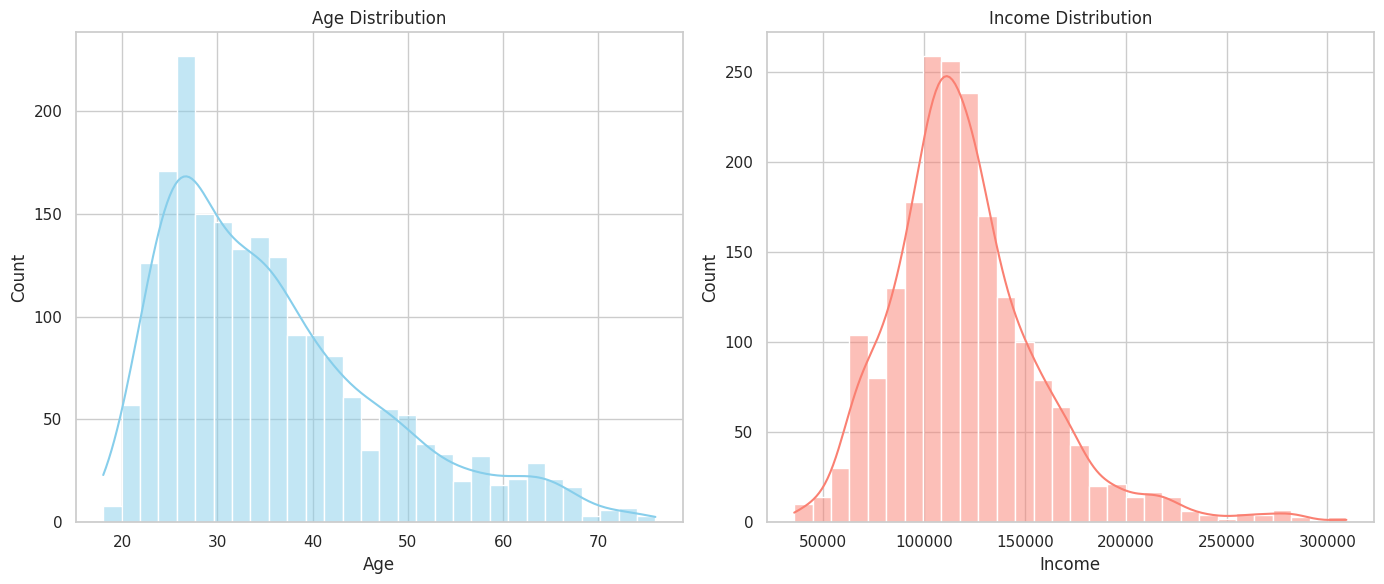

In [ ]:
# aqui plotei um grafico para ver como esta a distrubuição dos dados em função da idade e da renda

fig, ax=plt.subplots(1,2, figsize=(14,6))

sns.histplot(df['Age'],bins=30,kde=True,color='skyblue',ax=ax[0])
ax[0].set_title('Age Distribution')

sns.histplot(df['Income'],bins=30,kde=True,color='salmon',ax=ax[1])
ax[1].set_title('Income Distribution')
plt.tight_layout()
plt.show()



*   No 1° gráfico vemos que é uma distribuição assimétrica, a maioria dos dados estão para a esquedas, podemos concluir qque temos um pico entre 20 a 30 anos, mas a concentração geral esta entre 20 a 40 anos.

*   Mesma coisa no 2° gráfico, vemos que a maioria dos dados estão para a esqueda, e a maioria esta concentrado numa faixa de renda de 50k a 150k de dolares anuais



In [ ]:
# O código limita os valores de renda ao percentil 99%, evitando que valores muito altos (possíveis outliers) influenciem análises ou modelos de machine learning.
income_cap=df['Income'].quantile(0.99)
df['Income']=df['Income'].clip(upper=income_cap)

In [ ]:
#Esse trecho de código aplica normalização (Min-Max Scaling) às colunas 'Age' e 'Income'
scaler=MinMaxScaler()
df[['Age','Income']]=scaler.fit_transform(df[['Age','Income']])

In [ ]:
# minhas colunas pós normalizção
df[['Age','Income']].describe()

,Age,Income
count,2000.000000,2000.000000
mean,0.308776,0.377426
std,0.202059,0.165787
min,0.000000,0.000000
25%,0.155172,0.274786
50%,0.258621,0.354270
75%,0.413793,0.454368
max,1.000000,1.000000


<Axes: >

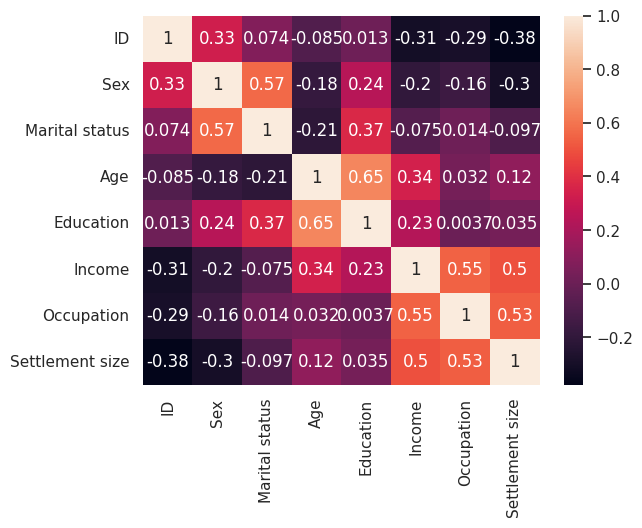

In [ ]:
# aqui exibi meu heatmap com seaborn simplesmente
sns.heatmap(df.corr(),annot=True)



*   Forte relação entre renda e ocupação: Clientes em categorias ocupacionais mais altas geralmente relatam rendas mais altas.

*   Forte relação entre idade e educação: Indivíduos mais velhos tendem a ter níveis de escolaridade mais elevados.



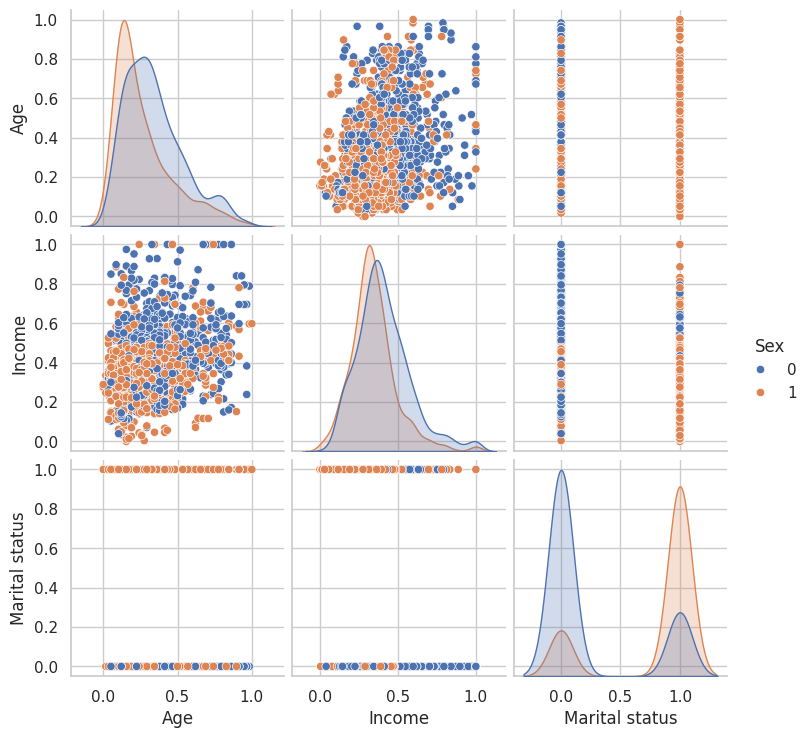

In [ ]:
#Esse código usa o seaborn (importado como sns) para criar um pairplot, que é um gráfico de dispersão cruzado entre variáveis numéricas, com uma coloração (hue) baseada em uma variável categórica.
sns.pairplot(df[['Age', 'Income', 'Sex', 'Marital status']], hue='Sex')

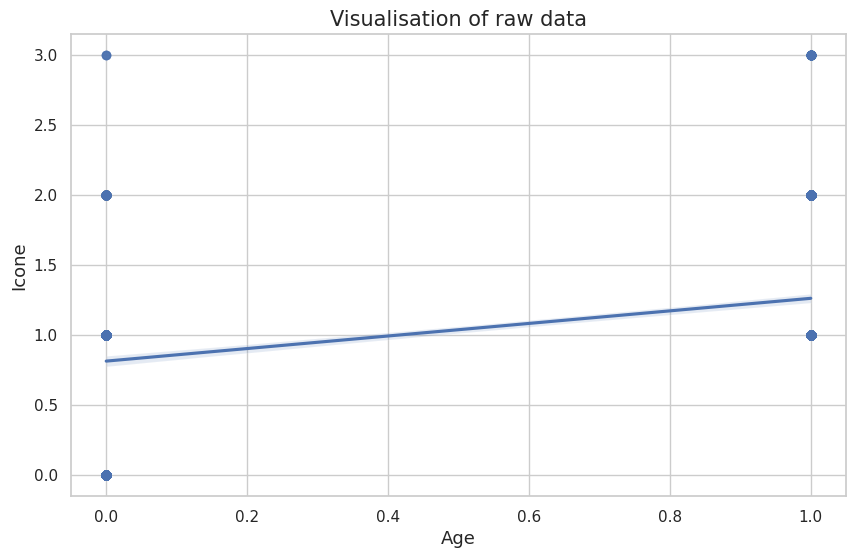

In [ ]:
#Esse trecho de código cria um gráfico de dispersão com linha de regressão usando matplotlib e seaborn.

plt.figure(figsize=(10,6))
sns.regplot(x=df.iloc[:,2],y=df.iloc[:,4])
plt.xlabel('Age', fontsize=13)
plt.ylabel('Icone', fontsize=13)
plt.title('Visualisation of raw data', fontsize=15)
plt.show()



*  Visualizando a relação entre renda e idade:
O uso de um gráfico de dispersão com uma linha de regressão nos permitirá avaliar visualmente a relação entre renda e idade. A linha de regressão ajudará a ilustrar a tendência, mostrando se a renda tende a aumentar ou diminuir com a idade.


In [ ]:
#Esse código aplica a padronização (z-score normalization) aos dados do DataFrame ATENÇÃO: ESSA LINHA DE CÓDIGO É DE SUMA IMPORTÂNCIA DO QUE VIRA PELA FRENTE
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# 4.0 Treinamento do modelo

In [ ]:
df=pd.read_csv(r'/content/sgdata.csv')

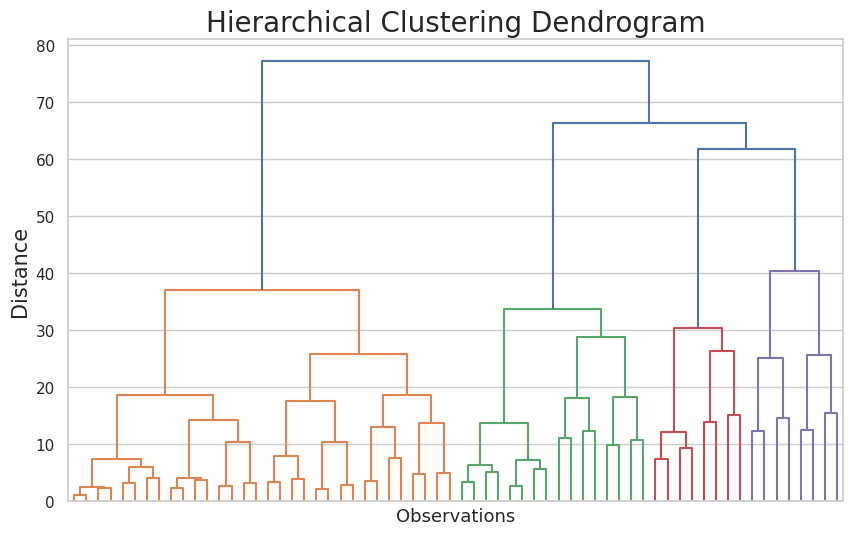

In [ ]:
# após testar outros métodos, o ward teve uma melhor silhueta e teve uma separação mais orgânica
# descobri um método interessante para definir o numero de clusters o que é de suma importância no algoritmo kmenas que é o dendograma.

hier_clust = linkage(df_scaled, method='ward')

plt.figure(figsize=(10,6))
plt.title('Hierarchical Clustering Dendrogram',fontsize=20)
plt.ylabel('Distance',fontsize=15)
plt.xlabel('Observations',fontsize=13)
dendrogram(hier_clust,show_leaf_counts=True,truncate_mode='level',p=5,no_labels=True)
plt.show()

In [ ]:
#Esse código está implementando a técnica do cotovelo (elbow method) para ajudar a determinar o número ideal de clusters em uma análise de agrupamento com K-Means.
wcss={}
for i in range(1,11):
  kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
  kmeans.fit(df_scaled)
  wcss[i]=kmeans.inertia_

In [ ]:
wcss

{1: 15999.99999999998,
 2: 12137.434562107135,
 3: 10182.468502530299,
 4: 9328.461754984279,
 5: 8491.613788691815,
 6: 7034.83255719822,
 7: 6670.7318871548105,
 8: 6234.40144618994,
 9: 5899.071093373185,
 10: 5447.002557112838}

Text(0.5, 1.0, 'K-means Clustering - Elbow Method')

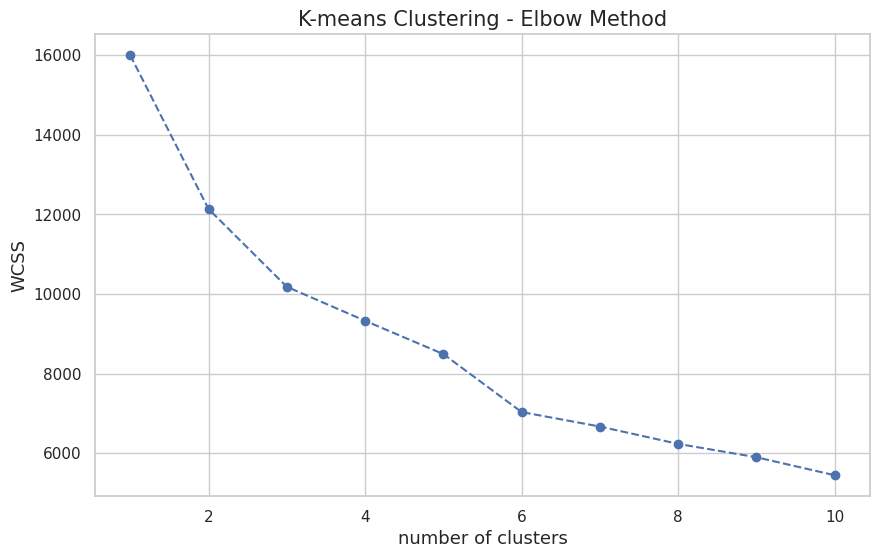

In [ ]:
# aqui plotei a expressão grafica do wcss

plt.figure(figsize=(10,6))
plt.plot(list(wcss.keys()), list(wcss.values()),  marker = 'o', linestyle = '--' )
plt.xlabel('number of clusters',fontsize=13)
plt.ylabel('WCSS',fontsize=13)
plt.title('K-means Clustering - Elbow Method', fontsize = 15)

In [ ]:
# aqui é definido que a melhor quantidade de k para usar no modelo é 5
x, y = list(wcss.keys()), list(wcss.values())
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print('O melhor numero de clusters: ', 5)

O melhor numero de clusters:  5


## Feito o treianemnto do modelo

In [ ]:
# aqui para mim é uma das partes mais legais, simplesmente testei o algoritmo com varios clusters e vi qual tinha o melhor resultado com base na métrica silhouette_score
silhouette_scores = []

# Laço de 3 a 7
for k in range(3, 8):
    # Inicializa e ajusta o modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)

    # Calcula o silhouette score
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

    print(f'k={k}, Silhouette Score: {score:.4f}')

# Encontra o melhor k
best_k = range(3, 8)[silhouette_scores.index(max(silhouette_scores))]
print(f'Melhor k: {best_k} com Silhouette Score: {max(silhouette_scores):.4f}')

k=3, Silhouette Score: 0.2361
k=4, Silhouette Score: 0.2215
k=5, Silhouette Score: 0.2287
k=6, Silhouette Score: 0.2588
k=7, Silhouette Score: 0.2421
Melhor k: 6 com Silhouette Score: 0.2588


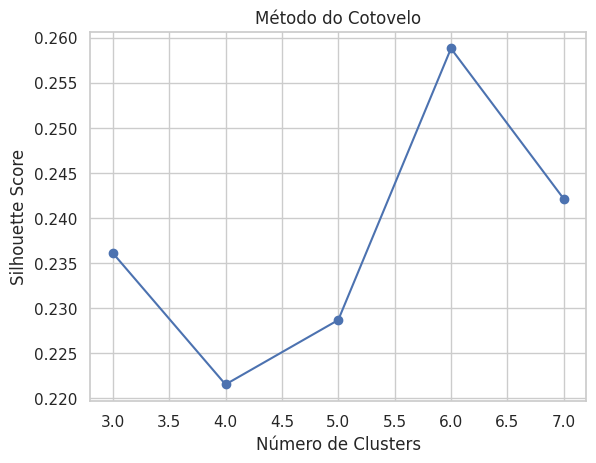

In [ ]:
#aqui eu fiz um grafico para ter uma dimensão de diferente entre os numeros de clusters

plt.plot(range(3, 8), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Método do Cotovelo')
plt.show()

In [ ]:
# aqui atribui a coluna custers, ou seja, qual cluster cada linha pertence
kmeans=KMeans(n_clusters=6,random_state=42)
kmeans.fit(df_scaled)
df['Cluster']=kmeans.labels_

In [ ]:
# aqui eu verifiquei como ficou o dataset
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Cluster
0,100000001,0,single,67,university,124670,skilled employee / official,2,5
1,100000002,1,non-single (divorced / separated / married / w...,22,high school,150773,skilled employee / official,2,4
2,100000003,0,single,49,high school,89210,unemployed / unskilled,0,2
3,100000004,0,single,45,high school,171565,skilled employee / official,1,0
4,100000005,0,single,53,high school,149031,skilled employee / official,1,0


In [ ]:
# agrupei cada cluster para ver a quantidade de cada um
df.groupby('Cluster').size()

,0
Cluster,
0,525
1,319
2,231
3,359
4,317
5,249


In [ ]:
# Selecionar colunas numéricas e calculei estatísticas descritivas para colunas numéricas
numeric_cols = ['Age', 'Income', 'Sex', 'Settlement size']


cluster_summary_numeric = df.groupby('Cluster')[numeric_cols].agg({
    'Age': ['mean', 'median', 'std'],
    'Income': ['mean', 'median', 'std'],
    'Sex': ['mean'],  # Proporção de Sex=1 (ex.: feminino)
    'Settlement size': ['mean']
})
print("Resumo Numérico dos Clusters:")
print(cluster_summary_numeric)

Resumo Numérico dos Clusters:
               Age                           Income                          \
              mean median        std           mean    median           std   
Cluster                                                                       
0        36.910476   36.0   8.588870  139478.487619  133243.0  32788.895940   
1        29.821317   29.0   6.203776  113688.871473  112227.0  13071.451610   
2        35.839827   35.0   9.493493   89885.705628   84779.0  23377.575284   
3        32.916435   30.0   9.660363   87327.963788   86319.0  20718.802620   
4        28.123028   28.0   5.121993  127664.381703  118428.0  30789.674760   
5        55.887550   57.0  10.445877  159967.614458  149410.0  44328.190808   

              Sex Settlement size  
             mean            mean  
Cluster                            
0        0.000000        1.325714  
1        0.852665        0.275862  
2        0.000000        0.116883  
3        0.952646        0.000000  
4     

In [ ]:
#aqui eu vi a distribuição de cada coluna coluna categórica para cada cluster
categorical_cols = ['Marital status', 'Education', 'Occupation']

for col in categorical_cols:
    print(f"\nDistribuição de {col} por Cluster:")
    print(pd.crosstab(df['Cluster'], df[col], normalize='index'))


Distribuição de Marital status por Cluster:
Marital status  non-single (divorced / separated / married / widowed)  \
Cluster                                                                 
0                                                        0.000000       
1                                                        0.702194       
2                                                        0.142857       
3                                                        0.690808       
4                                                        1.000000       
5                                                        0.686747       

Marital status    single  
Cluster                   
0               1.000000  
1               0.297806  
2               0.857143  
3               0.309192  
4               0.000000  
5               0.313253  

Distribuição de Education por Cluster:
Education  graduate school  high school  other / unknown  university
Cluster                                      

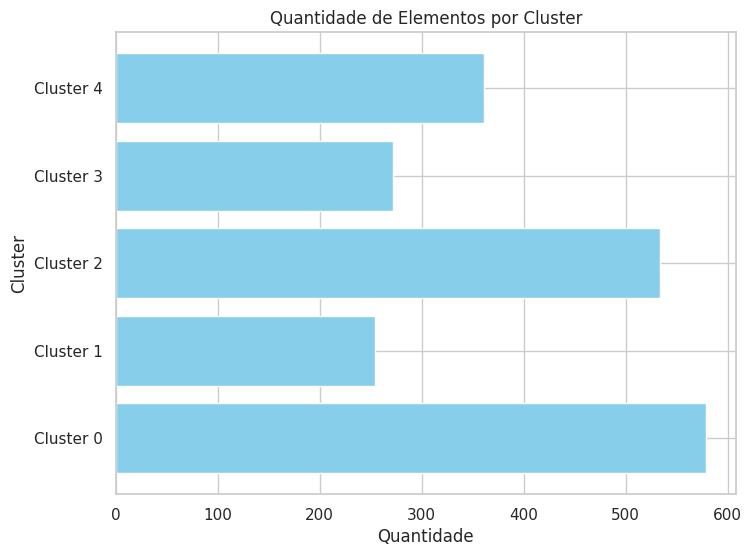

In [ ]:
# aqui eu exibi a quantidade de cada clusters de forma grafica

clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
quantities = [579, 254, 534, 272, 361]


plt.figure(figsize=(8, 6))
plt.barh(clusters, quantities, color='skyblue')


plt.xlabel('Quantidade')
plt.ylabel('Cluster')
plt.title('Quantidade de Elementos por Cluster')

plt.show()

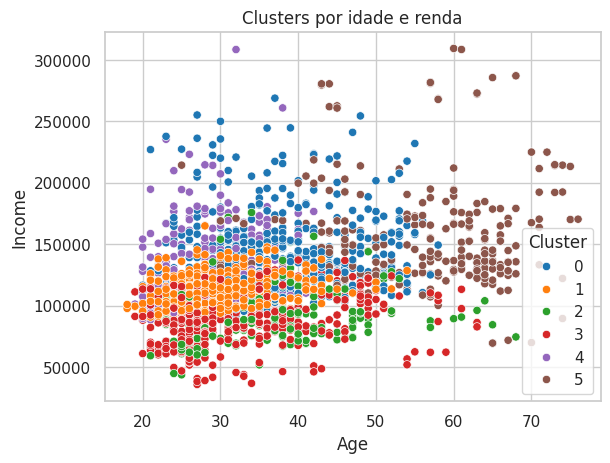

In [ ]:
# distribui esses dados e colori para difrenciar o peretecimente de cada dado para cada cluster

sns.scatterplot(x='Age',y='Income',hue='Cluster',palette='tab10',data=df)
plt.title('Clusters por idade e renda')
plt.show()

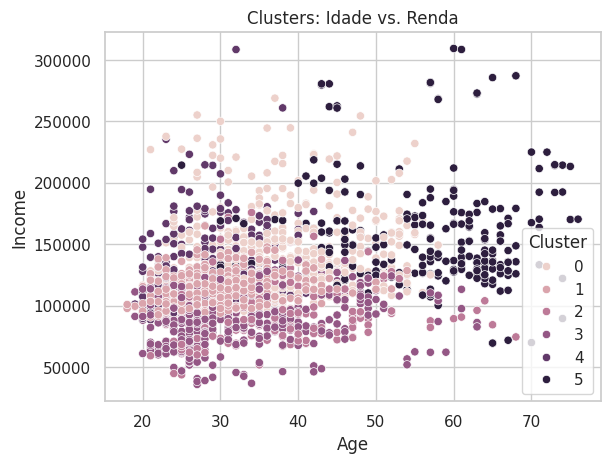

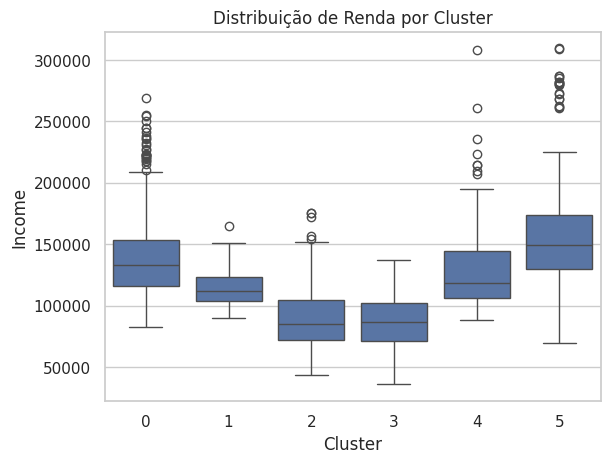

In [ ]:
# Visualização: Dispersão de Age vs. Income
sns.scatterplot(x='Age', y='Income', hue='Cluster', data=df)
plt.title('Clusters: Idade vs. Renda')
plt.show()

# Visualização: Boxplot de Income por Cluster
sns.boxplot(x='Cluster', y='Income', data=df)
plt.title('Distribuição de Renda por Cluster')
plt.show()